## Imports

In [4]:
# pip install --upgrade scikit-learn


In [31]:
import time
from IPython.display import clear_output
import numpy    as np
import pandas   as pd
import seaborn  as sb
import matplotlib.pyplot as plt

import sklearn
from sklearn import pipeline      # Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler # OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn import compose
from sklearn.model_selection import train_test_split # train_test_split
from sklearn import metrics         # accuracy_score, balanced_accuracy_score, plot_confusion_matrix
from sklearn import set_config

set_config(display='diagram') # Useful for display the pipeline

print("Pandas  ", pd.__version__)
print("Sklearn ", sklearn.__version__) # Try to use 0.24

Pandas   1.4.1
Sklearn  1.0.2


## Get the dataset
- **CLOUD = True**: Download dataset from Kaggle. Necesary for cloud enviroments like COLAB. **Specify your [kaggle credentials](https://www.kaggle.com/docs/api)**.
- **CLOUD = False**: Get the dataset from your local machine. **Specify the data path**.

In [6]:
DATA_PATH = "./titanic/"

## Load data

In [7]:
df      = pd.read_csv(DATA_PATH + "train.csv", index_col='PassengerId')
df_test = pd.read_csv(DATA_PATH + "test.csv",  index_col='PassengerId')

print("Train DataFrame:", df.shape)
print("Test DataFrame: ", df_test.shape)

Train DataFrame: (891, 11)
Test DataFrame:  (418, 10)


In [42]:
df.dtypes

Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
Title        object
dtype: object

In [40]:
df.sample(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S,Master
676,0,3,"Edvardsson, Mr. Gustaf Hjalmar",male,18.0,0,0,349912,7.7750,NaN,S,Mr
415,1,3,"Sundman, Mr. Johan Julian",male,44.0,0,0,STON/O 2. 3101269,7.9250,NaN,S,Mr
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C,Mr
519,1,2,"Angle, Mrs. William A (Florence ""Mary"" Agnes H...",female,36.0,1,0,226875,26.0000,NaN,S,Mrs
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C,Mr
59,1,2,"West, Miss. Constance Mirium",female,5.0,1,2,C.A. 34651,27.7500,NaN,S,Miss
285,0,1,"Smith, Mr. Richard William",male,NaN,0,0,113056,26.0000,A19,S,Mr
205,1,3,"Cohen, Mr. Gurshon ""Gus""",male,18.0,0,0,A/5 3540,8.0500,NaN,S,Mr


In [41]:
df_test.sample(10)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
913,3,"Olsen, Master. Artur Karl",male,9.0,0,1,C 17368,3.1708,NaN,S,Master
1088,1,"Spedden, Master. Robert Douglas",male,6.0,0,2,16966,134.5000,E34,C,Master
1179,1,"Snyder, Mr. John Pillsbury",male,24.0,1,0,21228,82.2667,B45,S,Mr
1205,3,"Carr, Miss. Jeannie",female,37.0,0,0,368364,7.7500,NaN,Q,Miss
1059,3,"Ford, Mr. Edward Watson",male,18.0,2,2,W./C. 6608,34.3750,NaN,S,Mr
1187,3,"Angheloff, Mr. Minko",male,26.0,0,0,349202,7.8958,NaN,S,Mr
1032,3,"Goodwin, Miss. Jessie Allis",female,10.0,5,2,CA 2144,46.9000,NaN,S,Miss
928,3,"Roth, Miss. Sarah A",female,NaN,0,0,342712,8.0500,NaN,S,Miss
1233,3,"Lundstrom, Mr. Thure Edvin",male,32.0,0,0,350403,7.5792,NaN,S,Mr


## Check missings

In [10]:
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [11]:
df_test.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

`Age` and `Cabin` are missing data in both training and test sets. Missing values in `Cabin` are way higher, might be a good idea to drop the whole column.

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

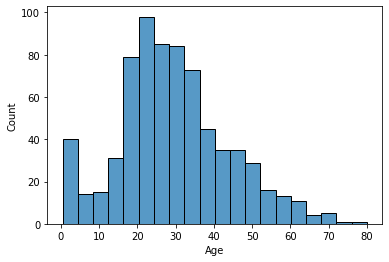

In [36]:
# How is Age distributed?

sb.histplot(x = df['Age'])

df['Age'].describe()


The `Age` is skewed to the right. While looking for a better way to replace missing values (e.g. based on some grouping factor, or KNN), we'll use the median as replacement.   
Also something noticeable is that the mininum age is 0.42 (probably because they are converting months to years).

In [43]:
df.Age.value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: Age, Length: 88, dtype: int64

# Exercise 1 (2pts):
Extract the title (Mr, Mrs, ... ) from the "Name" column.

Tips:
- split(',')[1] to get the 2nd part, and remove the surnamename
- split('.')[0] to get the 1str part, and remove the name

In [12]:
# CODE HERE get_Title_from_Name funtion
# Create this function using lambda (not def)

get_Title_from_Name = lambda x: x.split(',')[1].split('.')[0].strip()

df['Title'] = df['Name'].apply(get_Title_from_Name)
df_test['Title'] = df_test['Name'].apply(get_Title_from_Name)

In [17]:
df.Title.value_counts(), df_test.Title.value_counts()

(Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Mlle              2
 Major             2
 Col               2
 the Countess      1
 Capt              1
 Ms                1
 Sir               1
 Lady              1
 Mme               1
 Don               1
 Jonkheer          1
 Name: Title, dtype: int64,
 Mr        240
 Miss       78
 Mrs        72
 Master     21
 Col         2
 Rev         2
 Ms          1
 Dr          1
 Dona        1
 Name: Title, dtype: int64)

In [53]:
assert df['Title'].values[0] == "Mr"
assert df['Title'].values[1] == "Mrs"
assert df['Title'].values[2] == "Miss"

assert df_test['Title'].values[0] == "Mr"
assert df_test['Title'].values[1] == "Mrs"
assert df_test['Title'].values[414] == "Dona"

# Exercise 2 (1pts):
Apply the title_dictionary to get a better information about the title. You have to overwrite the Title variable.

In [19]:
title_dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty"
}

In [21]:
# Use map to apply the prevous dict

df['Title'] = df['Title'].map(title_dictionary) 
df_test["Title"] = df_test['Title'].map(title_dictionary) 



In [22]:
assert df['Title'].values[886] == "Officer"
assert df_test['Title'].values[417] == "Master"

# Exercise OPTIONAL (0pts):
Try to extract some information from the feature **Ticket**. Search on Internet if that colum has some kind of information.

PassengerId
892                 330911
893                 363272
894                 240276
895                 315154
896                3101298
               ...        
1305             A.5. 3236
1306              PC 17758
1307    SOTON/O.Q. 3101262
1308                359309
1309                  2668
Name: Ticket, Length: 418, dtype: object

# Exercise OPTIONAL (0pts):
Try to extract some information from the feature **Cabin**. Search on Internet if that colum has some kind of information.

PassengerId
892      NaN
893      NaN
894      NaN
895      NaN
896      NaN
        ... 
1305     NaN
1306    C105
1307     NaN
1308     NaN
1309     NaN
Name: Cabin, Length: 418, dtype: object

# Preprocessing
For X data, notice that...
- We drop Survived because is the target variable
- We drop Name because we have extracted the Title: Mr, Mrs, ...
- We drop Ticket because it has no information -> see df.Ticket.nunique()
- We drop Cabin because it has a lot of missings (77% are missings)

Then, we identify **numerical** variables and **categorical** variables,

In [27]:
x = df.drop(columns=["Survived", 'Name', 'Ticket', 'Cabin']) # X DATA (WILL BE TRAIN+VALID DATA)
y = df["Survived"] # 0 = No, 1 = Yes

x_test = df_test.drop(columns=['Name', 'Ticket', 'Cabin']) # # X_TEST DATA (NEW DATA)

In [28]:
print(x.shape, y.shape, x_test.shape)

(891, 8) (891,) (418, 8)


In [29]:
cat_vars  = ['Sex', 'Embarked', 'Title']         # x.select_dtypes(include=[object]).columns.values.tolist()
num_vars  = ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age'] # x.select_dtypes(exclude=[object]).columns.values.tolist()

print("\nNumerical features:\n", num_vars)
print("\nCategorical features:\n", cat_vars)


Numerical features:
 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']

Categorical features:
 ['Sex', 'Embarked', 'Title']


# Exercise 3 (2pts):
Create a **ColumnTransformer for Tree Models**. You need to create 2 pipelines (one for numerical and other for categories). Remember:
- Categorical pipeline: Some SimpleImputer -> Some Encoder
- Numerical pipeline: Some SimpleImputer -> NO Encoder

In [39]:
"""
num_preprocessing = pipeline.Pipeline(steps=[
  # Some SimpleImputer here
])

cat_preporcessing = pipeline.Pipeline(steps=[
  # Some SimpleImputer here
  # Some Encoder here. Remember to handle_unknown
])

tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_preprocessing, num_vars),
    ('cat', cat_preporcessing, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_prepro
""";

### BEGIN SOLUTION


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['Pclass', 'SibSp', 'Parch', 'Fare', 'Age']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='missing',
                                                                strategy='constant')),
                                                 ('ordinal',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=10))]),
                                 ['Sex', 'Embarked', 'Title'])])

In [ ]:
num_preprocessing = pipeline.Pipeline(steps=[
  SimpleImputer(strategy='mean')
])

cat_preporcessing = pipeline.Pipeline(steps=[
  # Some SimpleImputer here
  # Some Encoder here. Remember to handle_unknown
])

tree_prepro = compose.ColumnTransformer(transformers=[
    ('num', num_preprocessing, num_vars),
    ('cat', cat_preporcessing, cat_vars),
], remainder='drop') # Drop other vars not specified in num_vars or cat_vars

tree_prepro

In [40]:
assert type(tree_prepro)      is compose._column_transformer.ColumnTransformer
assert type(num_4_treeModels) is pipeline.Pipeline
assert type(cat_4_treeModels) is pipeline.Pipeline
assert len(num_4_treeModels) == 1
assert len(cat_4_treeModels) == 2

# Exercise 4 (1pts):
1. Complete the diccionary with some Tree Models.
2. Then we put each model in a Pipeline where:
   - first is the prepocessing with the column Transformer
   - Then is the Tree model
3. Display the fullpipeline of the LGBMClassifier

In [41]:
from sklearn.tree          import DecisionTreeClassifier
from sklearn.ensemble      import RandomForestClassifier
from sklearn.ensemble      import ExtraTreesClassifier
from sklearn.ensemble      import AdaBoostClassifier
from sklearn.ensemble      import GradientBoostingClassifier
from sklearn.experimental  import enable_hist_gradient_boosting # Necesary for HistGradientBoostingClassifier
from sklearn.ensemble      import HistGradientBoostingClassifier
from xgboost               import XGBClassifier
from lightgbm              import LGBMClassifier
from catboost              import CatBoostClassifier

In [42]:
"""
tree_classifiers = {
  "Decision Tree": DecisionTreeClassifier(),
  "Extra Trees":
  "Random Forest":
  "AdaBoost":
  "Skl GBM":
  "Skl HistGBM":
  "XGBoost":
  "LightGBM":
  "CatBoost":
tree_classifiers = {name: pipeline.make_pipeline(tree_prepro, model) for name, model in tree_classifiers.items()}
tree_classifiers["LightGBM"]
"""




Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=10))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('lgbmclassifier', LGBMClassifier())])

In [43]:
for pipe in tree_classifiers.values():
    assert type(pipe) is pipeline.Pipeline

# Exercise 5 (3pts):
Define a simple split validation strategy with:
- 80% for train
- 20% for validation
- With stratification
- random_state=0

And train all the models in a for loop

In [44]:
"""
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    # CODE HERE
)
"""

results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

"""
for model_name, model in tree_classifiers.items():
    start_time = time.time()
    
    # FOR EVERY PIPELINE (PREPRO + MODEL) -> TRAIN WITH TRAIN DATA (x_train)
    
    # GET PREDICTIONS USING x_val
    pred = # CODE HERE

    total_time = time.time() - start_time

    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
                              
                              
"""

### BEGIN SOLUTION




results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

C:\Users\Jon\.conda\envs\NLP\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
[08:59:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.073611
0:	learn: 0.6694333	total: 149ms	remaining: 14.8s
1:	learn: 0.6480457	total: 150ms	remaining: 7.36s
2:	learn: 0.6295837	total: 151ms	remaining: 4.87s
3:	learn: 0.6077415	total: 151ms	remaining: 3.63s
4:	learn: 0.5921743	total: 152ms	remaining: 2.89s
5:	learn: 0

,Model,Accuracy,Bal Acc.,Time
1,Skl GBM,86.592179,85.039526,0.071807
2,CatBoost,84.916201,82.865613,0.335109
3,XGBoost,83.798883,82.766798,0.067819
4,LightGBM,83.798883,82.766798,0.053856
5,AdaBoost,82.681564,82.127800,0.117685
6,Skl HistGBM,82.681564,81.317523,0.354052
7,Random Forest,82.122905,80.592885,0.111702
8,Extra Trees,80.446927,78.959157,0.096741
9,Decision Tree,76.536313,75.777339,0.010972


In [45]:
assert results_ord["Accuracy"].min() > 75
assert results_ord["Bal Acc."].min() > 75
assert len(results_ord) == 9

# Exercise 6 (3pts):
Define a 10 Fold cross validation strategy with:
- With stratification
- shuffle=True
- random_state=0

And train all the models in a for loop.

Tip you can use **[cross_val_predict](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)** for both training and predict with 

In [46]:
"""
skf = model_selection.StratifiedKFold(
    # CODE HERE
)
"""



results = pd.DataFrame({'Model': [], 'Accuracy': [], 'Bal Acc.': [], 'Time': []})

"""
for model_name, model in tree_classifiers.items():
    start_time = time.time()
        
    # TRAIN AND GET PREDICTIONS USING cross_val_predict() and x,y
    pred = # CODE HERE

    total_time = time.time() - start_time

    results = results.append({"Model":    model_name,
                              "Accuracy": metrics.accuracy_score(y_val, pred)*100,
                              "Bal Acc.": metrics.balanced_accuracy_score(y_val, pred)*100,
                              "Time":     total_time},
                              ignore_index=True)
                              
                              
"""


results_ord = results.sort_values(by=['Accuracy'], ascending=False, ignore_index=True)
results_ord.index += 1 
results_ord.style.bar(subset=['Accuracy', 'Bal Acc.'], vmin=0, vmax=100, color='#5fba7d')

ms	remaining: 190ms
20:	learn: 0.4379520	total: 48.4ms	remaining: 182ms
21:	learn: 0.4337524	total: 49.1ms	remaining: 174ms
22:	learn: 0.4304046	total: 49.7ms	remaining: 166ms
23:	learn: 0.4268015	total: 50.7ms	remaining: 160ms
24:	learn: 0.4234316	total: 51.7ms	remaining: 155ms
25:	learn: 0.4199055	total: 52.7ms	remaining: 150ms
26:	learn: 0.4162630	total: 53.6ms	remaining: 145ms
27:	learn: 0.4137693	total: 54.3ms	remaining: 140ms
28:	learn: 0.4119374	total: 55.2ms	remaining: 135ms
29:	learn: 0.4097722	total: 56ms	remaining: 131ms
30:	learn: 0.4074941	total: 56.9ms	remaining: 127ms
31:	learn: 0.4055535	total: 57.8ms	remaining: 123ms
32:	learn: 0.4033087	total: 58.8ms	remaining: 119ms
33:	learn: 0.4012196	total: 59.7ms	remaining: 116ms
34:	learn: 0.3991772	total: 60.6ms	remaining: 113ms
35:	learn: 0.3972488	total: 61.5ms	remaining: 109ms
36:	learn: 0.3961493	total: 62.4ms	remaining: 106ms
37:	learn: 0.3944826	total: 63.3ms	remaining: 103ms
38:	learn: 0.3928820	total: 64.3ms	remaining: 

,Model,Accuracy,Bal Acc.,Time
1,Skl GBM,83.277217,81.027706,0.782907
2,CatBoost,82.716049,80.241588,1.593758
3,Skl HistGBM,82.491582,80.831176,3.700102
4,LightGBM,82.491582,80.886300,1.059167
5,Random Forest,82.042649,80.687374,1.328446
6,AdaBoost,81.930415,80.927044,1.246664
7,XGBoost,81.930415,80.430927,0.744010
8,Extra Trees,80.808081,79.354808,1.219739
9,Decision Tree,79.124579,77.933563,0.143615


In [47]:
assert results_ord["Accuracy"].min() > 75
assert results_ord["Bal Acc."].min() > 75
assert len(results_ord) == 9

# Exercise 7.1
Train with all data the best model

In [48]:
# best_model = tree_classifiers["SELECT MY BEST MODEL HERE"]

# Fit best model with all data



Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Pclass', 'SibSp', 'Parch',
                                                   'Fare', 'Age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=10))]),
                                                  ['Sex', 'Embarked',
                                                   'Title'])])),
                ('gradientboostingclassifier', GradientBoostingClassifier())])

# Exercise 7.2 (2pts)
With your best model, generate the predicitions for test data (x_test)

In [49]:
# test_pred = # Get the predictions for x_test



In [50]:
assert len(test_pred) == 418
assert np.unique(test_pred).tolist() == [0,1]

# Exercise 7.3

Submit to kaggle.

- You can use the kaggle command line app. Check https://github.com/Kaggle/kaggle-api

In [51]:
"""sub = pd.DataFrame(test_pred, index=x_test.index, columns=["Survived"])
sub.head()"""

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [52]:
'''sub.to_csv("sub.csv")'''

In [53]:
!kaggle competitions submit -c titanic -f sub.csv -m "My submission message"

'kaggle' is not recognized as an internal or external command,
operable program or batch file.
